# Import Libraries

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mutual_info_score, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold


/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare files

In [2]:
url_housing = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

data_dir = Path.cwd().parent / "data"
csv_data = data_dir / "data.csv"

data_dir.mkdir(exist_ok=True)

with requests.Session() as s:
    r = s.get(url_housing)

with csv_data.open("wb") as f:
    f.write(r.content)


## Data Loading

In [3]:
df = pd.read_csv(csv_data)

df.head()


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [5]:
df.isna().sum()


Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

## Preparing the dataset

In [6]:
df_ori = df.copy()


In [7]:
df = df_ori.copy()

cols = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
]

df = df.loc[:, cols + ["MSRP"]]
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.fillna(0, inplace=True)
df["above_average"] = (df["msrp"] > df["msrp"].mean()).astype(int)


### Splitting the data

In [8]:
df_full_train, df_test = train_test_split(
    df, test_size=0.2, random_state=1
)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1
)


In [9]:
X_train, X_val, X_test = (_.drop(columns=["msrp", "above_average"]) for _ in [df_train, df_val, df_test])
y_train, y_val, y_test = (_["above_average"] for _ in [df_train, df_val, df_test])


In [10]:
numerical_cols = [
    "year",
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg",
]

categorical_cols = [
    "make",
    "model",
    "transmission_type",
    "vehicle_style",
]


In [11]:
df_train.head()


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27,50485,1
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18,26840,0
8450,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19,36490,0
2396,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17,43575,1
5494,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17,22595,0


In [12]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7148 entries, 5727 to 7918
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               7148 non-null   object 
 1   model              7148 non-null   object 
 2   year               7148 non-null   int64  
 3   engine_hp          7148 non-null   float64
 4   engine_cylinders   7148 non-null   float64
 5   transmission_type  7148 non-null   object 
 6   vehicle_style      7148 non-null   object 
 7   highway_mpg        7148 non-null   int64  
 8   city_mpg           7148 non-null   int64  
 9   msrp               7148 non-null   int64  
 10  above_average      7148 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 670.1+ KB


In [13]:
df_train.isna().sum()


make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
above_average        0
dtype: int64

## Question 1

In [14]:
pd.Series({col: auc(df_train.sort_values(by=col)[col], df_train.sort_values(by=col)["above_average"]) for col in numerical_cols}).sort_values(ascending=False)


engine_hp           684.0
highway_mpg         286.5
city_mpg             49.5
engine_cylinders     10.0
year                  5.0
dtype: float64

`engine_hp`

## Question 2

In [15]:
dv = DictVectorizer(sparse=False)
train_dict = X_train.to_dict(orient="records")
X_train_encoded = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient="records")
X_val_encoded = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train_encoded, y_train)

y_pred = model.predict_proba(X_val_encoded)[:, 1]


In [16]:
print("AUC Score:", round(roc_auc_score(y_val, y_pred), 3))


AUC Score: 0.98


## Question 3

In [17]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn, p, r))


/tmp/user/1000/ipykernel_65454/186250910.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


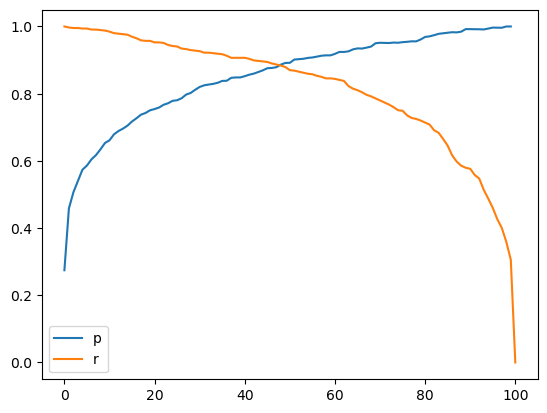

In [18]:
columns = ['t', 'tp', 'fp', 'fn', 'tn', "p", "r"]
df_scores = pd.DataFrame(scores, columns=columns)

df_scores[["p", "r"]].plot()
plt.show()


In [19]:
abs(df_scores["p"] - df_scores["r"]).sort_values().head()


48    0.002711
47    0.008062
49    0.012268
46    0.013402
45    0.018747
dtype: float64

`0.48`

## Question 4

In [20]:
df_scores["f1"] = 2 * (df_scores["p"] * df_scores["r"]) / (df_scores["p"] + df_scores["r"])
df_scores["f1"].sort_values(ascending=False).head()


49    0.885296
48    0.885145
45    0.885023
51    0.884735
52    0.883685
Name: f1, dtype: float64

Out of the options given, it's `0.52`

## Question 5

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train, df_val = (df_full_train.iloc[_] for _ in [train_idx, val_idx])
    X_train, X_val = (_.drop(columns=["msrp", "above_average"]) for _ in [df_train, df_val])
    y_train, y_val = (_["above_average"] for _ in [df_train, df_val])

    dv = DictVectorizer(sparse=False)
    train_dict = X_train.to_dict(orient="records")
    X_train_encoded = dv.fit_transform(train_dict)

    val_dict = X_val.to_dict(orient="records")
    X_val_encoded = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X_train_encoded, y_train)

    y_pred = model.predict_proba(X_val_encoded)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("Standard deviation:", round(np.std(scores), 3))


Standard deviation: 0.002


## Question 6

In [22]:
def train(df_train, y_train, C=1.0):
    dv = DictVectorizer(sparse=False)
    dicts = df_train[categorical_cols + numerical_cols].to_dict(orient='records')
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df[categorical_cols + numerical_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [23]:
C_scores = []
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train, df_val = (df_full_train.iloc[_] for _ in [train_idx, val_idx])
        y_train, y_val = (_["above_average"] for _ in [df_train, df_val])

        dv, model = train(df_train, y_train, C=C)

        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    C_scores.append({"c": C, "mean": np.mean(scores), "std": np.std(scores)})


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


In [24]:
pd.DataFrame(C_scores).sort_values(by=["mean", "std"], ascending=[False, True])


,c,mean,std
3,10.00,0.981339,0.003264
2,0.50,0.976935,0.001620
1,0.10,0.971799,0.001590
0,0.01,0.951623,0.002534


`10`